# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

In [1]:
# If this cell does not work try running `pip install nbformat`


# import io
import nbformat

nb = nbformat.read("Lab4.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 630


## Group Number : 1

## Student 1 
### Name : Athanasios Georgoutsos
### ID : 6015883

## Student 2
### Name : Amar Mesic
### ID : 5106117

## README

Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, roc_curve, auc

# data paths
data_X_path = "cda_lab4_data/X.npy"
data_y_path = "cda_lab4_data/y.npy"
feature_names_path = "cda_lab4_data/feature_names.csv"

## 1. Preparation (0 points)

### 1a. Load the dataset and split it into a train and test set

In [3]:
# load dataset
X = np.load(data_X_path)
print("X dimensions: ", X.shape)
y = np.load(data_y_path)
print("y dimensions: ", y.shape)

# load feature names
feature_names = pd.read_csv(feature_names_path, header=None)
print("Feature names: ", feature_names.head())

X dimensions:  (30396, 22761)
y dimensions:  (30396,)
Feature names:       0                               1
0  NaN                    feature_name
1  0.0        kernel32.dll:SetFileTime
2  1.0    kernel32.dll:CompareFileTime
3  2.0        kernel32.dll:SearchPathW
4  3.0  kernel32.dll:GetShortPathNameW


In [4]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size: ", len(y_train))
print("Train malwares: ", np.sum(y_train == 1))
print()
print("Test size: ", len(y_test))
print("Test malwares: ", np.sum(y_test == 1))

Train size:  24316
Train malwares:  12168

Test size:  6080
Test malwares:  3042


Train accuracy:  0.9201348906070077
Test accuracy:  0.9159539473684211
True negatives:  2945  - False positives:  93  - False negatives:  418  - True positives:  2624
Precision:  0.9657710710342289  - Recall: 0.8625904010519395  - F1 score:  0.9112693175898593
ROC AUC score:  0.9802612016366004


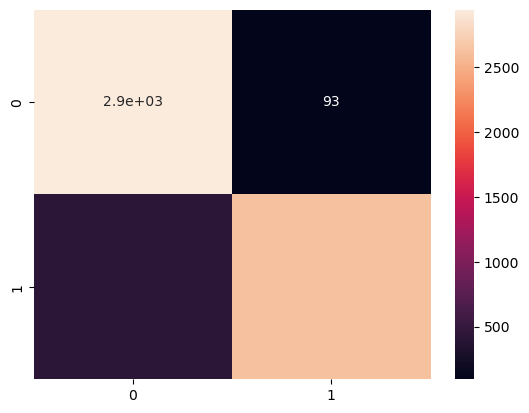

In [5]:
# NOTE: takes about 2 and a half minutes to run

# setup a logistic regression model
clf = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3)

# train the model
clf.fit(X_train, y_train)

# evaluate the model
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print("Train accuracy: ", train_score)
print("Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

### 1b. Initial Analysis

We begin by loading the AdvML malware dataset. It contains more than 30k sample windows executables, with binary features about the imports they include. We split them, in a stratified manner, in **train and test (80-20)** and, then, we train a SGD classifier with logistic regression loss on the former. The performance of the trained classifier on the test data is very good, achieving **a test accuracy of 91.84%** and, overall, making performing well in all our metrics.

## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [6]:
# experiment with coefficients

# get model's coefficients
coefficients = clf.coef_

# get two rows from train set
malware_row = X_train[y_train == 1][0]
benign_row = X_train[y_train == 0][0]

# calculate dot product with coefficients
malware_dot = malware_row.dot(coefficients.T)
benign_dot = benign_row.dot(coefficients.T)

# print the results
print("Malware dot product: ", malware_dot)
print("Benign dot product: ", benign_dot)

Malware dot product:  [3.38803478]
Benign dot product:  [-9.61253473]


In [7]:
def evade(sample, coef):

    best_x = sample
    k = 8

    while k > 0.5:
        
        # find most negative coefficients - leading to benign
        most_negative = np.argsort(coef)[0][:int(k)]

        # modify the sample
        x_mod = best_x.copy()
        # print(x_mod[most_negative])
        x_mod[most_negative] = 1

        # compute loss
        prev_best_loss = -np.dot(coef, best_x)
        new_loss = -np.dot(coef, x_mod)

        # print(prev_best_loss, new_loss)

        if new_loss > prev_best_loss:
            best_x = x_mod
            k *= 2
        else:
            k /= 2

    return best_x
        

In [9]:
# Example for a malware sample from the train set

# get model's coefficients
coefficients = clf.coef_

# get a malware row from test set
malware_row = X_train[y_train == 1][0]

# predict with clf
# get prediction for best_x
best_x_pred = clf.predict_proba([malware_row])[0]
print("Best x prediction: ", best_x_pred)

best_x = evade(malware_row, coefficients)
best_x_pred = clf.predict_proba([best_x])[0]
print("Evade prediction: ", best_x_pred)

Best x prediction:  [0.00438806 0.99561194]
Evade prediction:  [1.00000000e+000 1.35016954e-147]


Test accuracy:  0.484375
True negatives:  2945  - False positives:  93  - False negatives:  3042  - True positives:  0
Precision:  0.0  - Recall: 0.0  - F1 score:  nan


/var/folders/gn/8cmn0qdj1mx7g0mxnt5q722h0000gp/T/ipykernel_67674/3163729946.py:24: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)


ROC AUC score:  0.9802612016366004


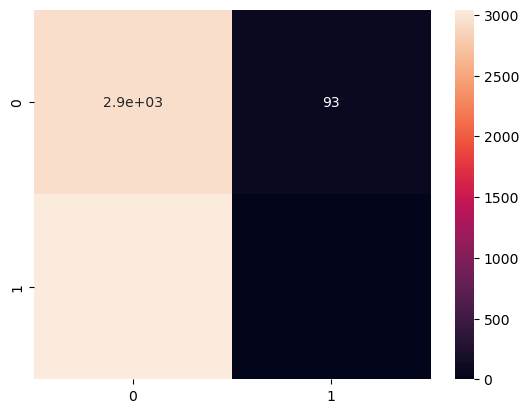

In [10]:
# NOTE: takes about 2 minutes to run

evade_rows = X_test.copy()

for i in range(len(evade_rows)):
    if y_test[i] == 1:
        evade_rows[i] = evade(evade_rows[i], coefficients)

test_score = clf.score(evade_rows, y_test)

# print("Train score: ", train_score)
print("Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf.predict(evade_rows)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

### 2b. Analysis and answers to the questions

We implemented the evade function by adapting the GRAMS method, from the provided paper. We noticed that the dot product of a malware row with the model coefficients was positive, while for the benign row was negative. So, in the evade function, our criterion for keep injecting imports to malware rows is that the dot product with the coefficient becomes more negative (worse for the model). We use the model trained earlier on the test set, after using evade. **Now, the model is unable to predict any malware rows (0!!!)**. The new test accuracy is 48.37%, while most of the other metrics drop as well. This means that **the model is not robust**, since a malware author, that knows how the coefficients of our model work, could easily modify his malware with targeted imports and remain undetected.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [125]:
def robust_training(X_train, y_train, clf, n_iter=100, batch_size=1000, one_pass=False, es_flag = False, es_tol = 10, evade=evade):
    
    # create batches of train data
    n_batches = len(y_train) // batch_size
    X_batches = np.array_split(X_train, n_batches)
    y_batches = np.array_split(y_train, n_batches)

    cnt = 0
    tol = 0

    best_clf = clf
    best_val_score = 0

    if one_pass:
        n_iter = n_batches

    while cnt < n_iter and tol < es_tol:
        
        print("Iteration: ", cnt)
       
        idx = cnt % n_batches

        if cnt == 0:
            clf.fit(X_batches[idx], y_batches[idx])
        
        else:

            batch_copy = X_batches[idx].copy()
            batch_labels = y_batches[idx].copy()

            coefficients = clf.coef_

            # use evade function on batch
            for j in range(len(batch_copy)):
                if batch_labels[j] == 1:
                    batch_copy[j] = evade(batch_copy[j], coefficients)
            
            clf.partial_fit(batch_copy, batch_labels)

        # check model performance on train set, with evade
        batch_copy = X_batches[idx].copy()
        batch_labels = y_batches[idx].copy()

        coefficients = clf.coef_

        # use evade function on batch
        for j in range(len(batch_copy)):
            if batch_labels[j] == 1:
                batch_copy[j] = evade(batch_copy[j], coefficients)

        # we consider this our validation score, for early stopping
        val_score = clf.score(batch_copy, batch_labels)
        print("Train accuracy with evade: ", val_score)
        
        y_pred = clf.predict(batch_copy)
        cm = confusion_matrix(batch_labels, y_pred)
        tn, fp, fn, tp = cm.ravel()

        print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

        if val_score > best_val_score:
            best_clf = clf
            best_val_score = val_score
            tol = 0
        elif es_flag:
            tol += 1

        cnt += 1

    return best_clf

In [13]:
# NOTE: takes about 10 minutes to run
# reduce the n_iter to 10 and disable early stopping for faster results

clf = SGDClassifier(loss="log_loss", tol=1e-3)

clf = robust_training(X_train, y_train, clf, n_iter=10, batch_size=1000, one_pass=True)

Iteration:  0
Train accuracy with evade:  0.49506903353057197
True negatives:  502  - False positives:  6  - False negatives:  506  - True positives:  0
Iteration:  1
Train accuracy with evade:  0.4921104536489152
True negatives:  499  - False positives:  0  - False negatives:  515  - True positives:  0
Iteration:  2
Train accuracy with evade:  0.5157790927021696
True negatives:  523  - False positives:  2  - False negatives:  489  - True positives:  0
Iteration:  3
Train accuracy with evade:  0.47731755424063116
True negatives:  484  - False positives:  2  - False negatives:  528  - True positives:  0
Iteration:  4
Train accuracy with evade:  0.5123395853899309
True negatives:  519  - False positives:  0  - False negatives:  494  - True positives:  0
Iteration:  5
Train accuracy with evade:  0.510365251727542
True negatives:  516  - False positives:  0  - False negatives:  496  - True positives:  1
Iteration:  6
Train accuracy with evade:  0.5222112537018756
True negatives:  522  - Fa

Test accuracy:  0.5307565789473684
True negatives:  2909  - False positives:  129  - False negatives:  2724  - True positives:  318
Precision:  0.7114093959731543  - Recall: 0.10453648915187377  - F1 score:  0.1822871883061049
ROC AUC score:  0.826028750878095


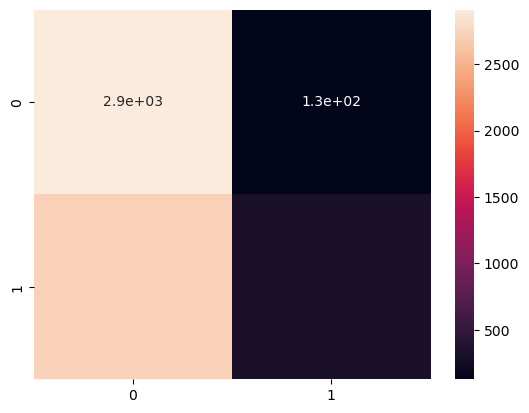

In [14]:
# check results without using evade

# evaluate the model
test_score = clf.score(X_test, y_test)

print("Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

Evade Test accuracy:  0.5032894736842105
True negatives:  2909  - False positives:  129  - False negatives:  2891  - True positives:  151
Precision:  0.5392857142857143  - Recall: 0.04963839579224195  - F1 score:  0.09090909090909091
ROC AUC score:  0.826028750878095


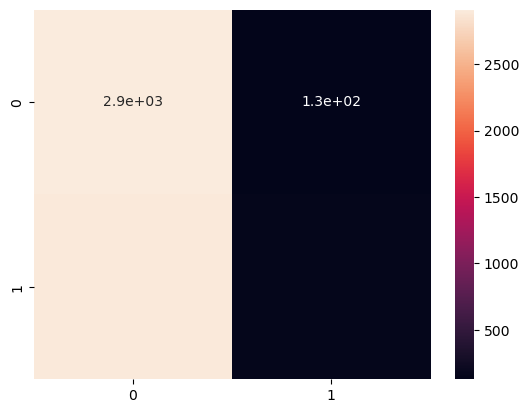

In [15]:
# NOTE: takes about 1 minute to run

coefficients = clf.coef_

evade_rows = X_test.copy()

for i in range(len(evade_rows)):
    if y_test[i] == 1:
        evade_rows[i] = evade(evade_rows[i], coefficients)

test_score = clf.score(evade_rows, y_test)

# print("Train score: ", train_score)
print("Evade Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf.predict(evade_rows)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

### 3b. Analysis and answers to the questions

We implemented robust training by creating train batches and applying evade to each of them before using them on the model. We also added early stopping, with respect to the accuracy of the model on the train batches, after re-applying evade (new coefficients because of training). This is what we care about, as our aim is to train a more robust model. Then, we evaluate it on the test data, with and without evade. 

We see a slight improvement on the test data with evade, as **the accuracy rises to 50.94% and there are 69 true positives**. However, we also see that **the performance on the original test degrades significantly**, with an accuracy of 51.85%. So, by robust training with evade, the model becomes more robust to adjusted malware, however it is not so effective in distinguishing between the original benign and malware windows exe files.

## 4. Training non-negative linear models (5 Points)

In [46]:
# setup a logistic regression model
clf_clip = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3)

# train the model
clf_clip.fit(X_train, y_train)

SGDClassifier(loss='log_loss')

### 4a. Implement non-negative logistic regression using SGD

In [127]:
def evade_clip(sample, coef):

    best_x = sample
    k = 8
    orig_x = sample.copy()
    counter = 0

    while k > 0.5:
        counter += 1

        prev_best_loss = -np.dot(coef, best_x)

        # find most negative coefficients - leading to benign
        most_negative = np.argsort(coef)[0][:int(k)]
        # print('most_negative indices: ', most_negative)
        # print('most negative values: ', coef[0][most_negative])

        # modify the sample
        x_mod = best_x.copy()
        x_mod[most_negative] = 1
        
        new_loss = -np.dot(coef, x_mod)
        # print(prev_best_loss, new_loss)

        # Clip coefficients to have values at least zero
        coef = np.clip(coef, 0, None)

        if new_loss > prev_best_loss:
            
            best_x = x_mod
            k *= 2
        else:
            k /= 2

    # print('counter: ', counter)
    return best_x
        

In [120]:
# Example for a malware sample from the train set

# get model's coefficients
coefficients = clf_clip.coef_

# get a malware row from test set
malware_row = X_train[y_train == 1][0]
malware_row_label = y_train[0]

# predict with clf
# get prediction for best_x
best_x_pred = clf_clip.predict_proba([malware_row])[0]
print("Best x prediction: ", best_x_pred)

# print('coefficients shape: ', coefficients.shape)
# print('coefficients: ', coefficients[0, :10])
print('malware_row: ', malware_row.shape)
print()

best_x = evade_clip(malware_row, coefficients)
best_x_pred = clf_clip.predict_proba([best_x])[0]
print("Evade prediction: ", best_x_pred)

Best x prediction:  [4.04287892e-06 9.99995957e-01]
malware_row:  (22761,)

coef:  (1, 22761)
coef pos:  (19390,)
coef:  (1, 22761)
coef pos:  (22761,)
coef:  (1, 22761)
coef pos:  (22761,)
coef:  (1, 22761)
coef pos:  (22761,)
coef:  (1, 22761)
coef pos:  (22761,)
coef:  (1, 22761)
coef pos:  (22761,)
Evade prediction:  [9.99984582e-01 1.54179192e-05]


### Test Classifier performance before applying changes to test set

Normal Test accuracy:  0.8638157894736842
True negatives:  3000  - False positives:  38  - False negatives:  790  - True positives:  2252
Precision:  0.9834061135371179  - Recall: 0.740302432610125  - F1 score:  0.8447111777944487
ROC AUC score:  0.941015112541167


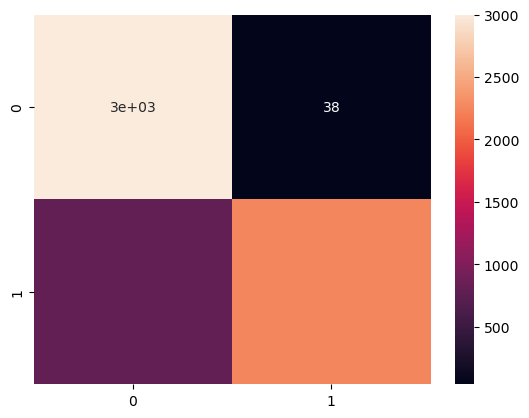

In [121]:
# NOTE: takes about 1 minute to run

coefficients = clf_clip.coef_

evade_rows = X_test.copy()

test_score = clf_clip.score(evade_rows, y_test)

# print("Train score: ", train_score)
print("Normal Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf_clip.predict(evade_rows)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf_clip.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

Adverse Test accuracy:  0.49407894736842106
True negatives:  3000  - False positives:  38  - False negatives:  3038  - True positives:  4
Precision:  0.09523809523809523  - Recall: 0.0013149243918474688  - F1 score:  0.002594033722438392
ROC AUC score:  0.941015112541167


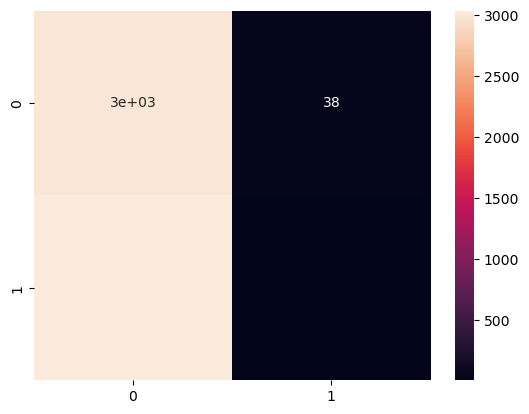

In [122]:
# NOTE: takes about 1 minute to run

coefficients = clf_clip.coef_

evade_rows = X_test.copy()

for i in range(len(evade_rows)):
    if y_test[i] == 1:
        evade_rows[i] = evade(evade_rows[i], coefficients)

test_score = clf_clip.score(evade_rows, y_test)

# print("Train score: ", train_score)
print("Adverse Test accuracy: ", test_score)

# plot the confusion matrix
y_pred = clf_clip.predict(evade_rows)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True negatives: ", tn, " - False positives: ", fp, " - False negatives: ", fn, " - True positives: ", tp)

# print F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: ", precision," - Recall:", recall, " - F1 score: ", f1)

# print roc auc score
roc = roc_auc_score(y_test, clf_clip.predict_proba(X_test)[:, 1])
print("ROC AUC score: ", roc)

sns.heatmap(cm, annot=True)
plt.show()

### 4b. Analysis and answers to the questions.

In [128]:
clf = robust_training(X_train, y_train, clf_clip, n_iter=10, batch_size=1000, one_pass=True, evade=evade_clip)

Iteration:  0
Train accuracy with evade:  0.49506903353057197
True negatives:  479  - False positives:  29  - False negatives:  483  - True positives:  23
Iteration:  1
Train accuracy with evade:  0.5029585798816568
True negatives:  444  - False positives:  55  - False negatives:  449  - True positives:  66
Iteration:  2
Train accuracy with evade:  0.5414201183431953
True negatives:  524  - False positives:  1  - False negatives:  464  - True positives:  25
Iteration:  3
Train accuracy with evade:  0.5226824457593688
True negatives:  473  - False positives:  13  - False negatives:  471  - True positives:  57
Iteration:  4
Train accuracy with evade:  0.5547877591312932
True negatives:  492  - False positives:  27  - False negatives:  424  - True positives:  70
Iteration:  5
Train accuracy with evade:  0.527147087857848
True negatives:  508  - False positives:  8  - False negatives:  471  - True positives:  26
Iteration:  6
Train accuracy with evade:  0.4876604146100691
True negatives:  

## 5. Bonus: robust decision trees for fraud detection (5 Points)

### 5a. Train and analyze a regular decision tree for fraud detection

### 5b. Train and analyze a robust decision tree (GROOT) for fraud detection

### 5c. Evaluate the robustness of the two models

## From Assignment Doc